## NLP Class Final Project Read Data

In [1]:
import pandas as pd
import re 
import nltk as nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import time
import math
import string
import gensim
import pyLDAvis
import seaborn as sns 
import matplotlib.pyplot as plt
#import pyLDAvis.gensim
#import pyLDAvis.gensim_models as gensimvis

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore

#pyLDAvis.enable_notebook()
#nlp = spacy.load("en_core_web_sm")

In [2]:
import pandarallel
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%%time

df_news_final_project = pd.read_parquet('/Users/parthbansal/Downloads/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 1.76 s, sys: 2.1 s, total: 3.85 s
Wall time: 5.01 s


(200332, 5)

In [4]:
df_news_final_project.head()

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,en,Artificial intelligence improves parking effic...,\n\nArtificial intelligence improves parking e...
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce..."
3,http://www.homeoffice.consumerelectronicsnet.c...,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Gl...,\n\nStrategy Analytics: 71% of Smartphones Sol...
4,http://www.itbusinessnet.com/2020/10/olympus-t...,2020-10-20,en,Olympus to Support Endoscopic AI Diagnosis Edu...,\n\nOlympus to Support Endoscopic AI Diagnosis...


### Data Preprocessing (Cleaning-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text)

In [5]:
# The articles are all in English 
df_news_final_project["language"].unique()

array(['en'], dtype=object)

In [6]:
# Dropping redudant columns 
df = df_news_final_project[["date","title","text"]]

In [7]:
# Converting to datetime format
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek

/var/folders/0y/n_xgd2n97837m629ymdq84rr0000gn/T/ipykernel_2804/2143503222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])
/var/folders/0y/n_xgd2n97837m629ymdq84rr0000gn/T/ipykernel_2804/2143503222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["date"].dt.year


In [8]:
print('Minimum date:', df['date'].min())

Minimum date: 2020-01-01 00:00:00


In [9]:
print('Maximum date:', df['date'].max())

Maximum date: 2023-04-28 00:00:00


In [10]:
def clean_text(text):
    # Removing unimportant characters (newlines,tabs)
    clean = re.sub(r'\n+|\t+|\s+$|^\s+', '', text) 
    
    # Removing unimportant characters
    clean = re.sub(r'[^a-zA-Z0-9 @ . , : - _ ]', '', clean) 
    
    # Remove URLs and email addresses
    clean = re.sub(r'http\S+|www.\S+|\S+@\S+', '', clean) 
    
    # Remove non-printable characters
    clean = ''.join(filter(lambda x: x.isprintable(), clean)) 
    
    # Remove non-ASCII characters
    clean = ''.join(filter(lambda x: ord(x) < 128, clean)) 
    
    # Replace multiple spaces with a single space
    clean = re.sub(r'\s+', ' ', clean)
    
    return clean

In [11]:
!pip install ipywidgets

In [12]:
%time df['clean_title'] = df['title'].parallel_apply(clean_text)

CPU times: user 54.2 ms, sys: 70.3 ms, total: 125 ms
Wall time: 950 ms


In [13]:
%time df['clean_text'] = df['text'].parallel_apply(clean_text)

CPU times: user 1.82 s, sys: 6.53 s, total: 8.35 s
Wall time: 1min 16s


In [14]:
df.sample(5, random_state = 42)

,date,title,text,year,month,day,dayofweek,clean_title,clean_text
178951,2022-11-30,"Ensuring Clinical AI Safety at Scale: deepc, C...","Ensuring Clinical AI Safety at Scale: deepc, C...",2022,11,30,2,"Ensuring Clinical AI Safety at Scale: deepc, C...","Ensuring Clinical AI Safety at Scale: deepc, C..."
135057,2023-02-07,"Google's Bard isn't Shakespeare, but instead a...","\n\nGoogle's Bard isn't Shakespeare, but inste...",2023,2,7,1,"Googles Bard isnt Shakespeare, but instead an ...","Googles Bard isnt Shakespeare, but instead an ..."
152219,2023-02-02,We asked the new AI to do some simple rocket s...,\nWe asked the new AI to do some simple rocket...,2023,2,2,3,We asked the new AI to do some simple rocket s...,We asked the new AI to do some simple rocket s...
174411,2022-06-28,Snackable AI - Share powerful moments from yo...,Snackable AI - Share powerful moments from yo...,2022,6,28,1,Snackable AI Share powerful moments from your ...,Snackable AI Share powerful moments from your ...
179106,2022-09-09,Codoxo Leads Payment Integrity AI Discussio...,\n Codoxo Leads Payment Integrity AI Discussi...,2022,9,9,4,Codoxo Leads Payment Integrity AI Discussion a...,Codoxo Leads Payment Integrity AI Discussion ...


### Discarding irrelevant articles

In [15]:
df["title_length"] = df["clean_title"].parallel_apply(lambda x : len(x.split()))

In [16]:
df["text_length"] = df["clean_text"].parallel_apply(lambda x : len(x.split()))

{'whiskers': [<matplotlib.lines.Line2D at 0x2a1264fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x2a1265510>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a1264d30>],
 'medians': [<matplotlib.lines.Line2D at 0x2a1265a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a1265cf0>],
 'means': []}

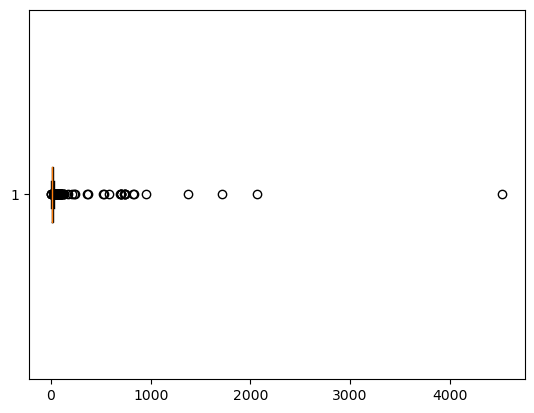

In [17]:
plt.boxplot(df['title_length'], vert = 0)

{'whiskers': [<matplotlib.lines.Line2D at 0x2a160b4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2a160ba30>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a160b370>],
 'medians': [<matplotlib.lines.Line2D at 0x2a160bf70>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a1638250>],
 'means': []}

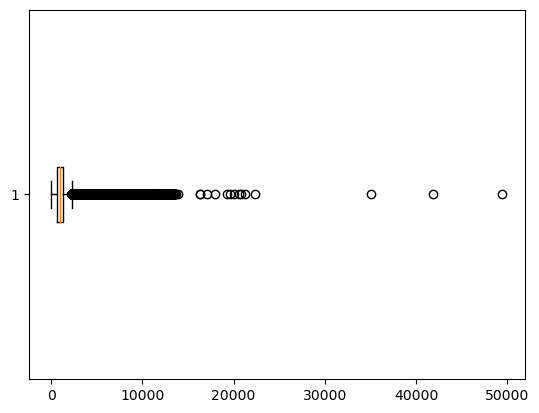

In [18]:
plt.boxplot(df['text_length'], vert = 0)

In [19]:
df["title_length"].describe(percentiles=[0.05,0.1, 0.5, 0.75, 0.95])

count    200332.000000
mean         14.369432
std          14.796071
min           1.000000
5%            8.000000
10%           9.000000
50%          13.000000
75%          17.000000
95%          25.000000
max        4526.000000
Name: title_length, dtype: float64

In [20]:
df["text_length"].describe(percentiles=[0.05,0.1, 0.5, 0.75, 0.95])

count    200332.000000
mean       1114.773646
std         872.042176
min           3.000000
5%          375.000000
10%         509.000000
50%         947.000000
75%        1329.000000
95%        2183.000000
max       49409.000000
Name: text_length, dtype: float64

In [21]:
# Dropping articles who's lenght for titles and text is below 5th percentile and above 95th percentile
new_df = df[(df['text_length']>370) & (df['text_length']<2185) & (df['title_length']>5) & (df['title_length']<26)]

In [22]:
# Dropping columns ['text_length', 'title_length']
new_df = new_df.drop(['text_length', 'title_length'], axis=1)

In [23]:
new_df.shape

(170984, 9)

In [24]:
new_df.sample(3, random_state = 42)

,date,title,text,year,month,day,dayofweek,clean_title,clean_text
84444,2021-03-30,Cambridge Quantum Computing Pioneers Quantum M...,Cambridge Quantum Computing Pioneers Quantum M...,2021,3,30,1,Cambridge Quantum Computing Pioneers Quantum M...,Cambridge Quantum Computing Pioneers Quantum M...
35622,2022-12-08,Aetina Launches New ASIC-Based Edge AI System ...,\n\nAetina Launches New ASIC-Based Edge AI Sys...,2022,12,8,3,Aetina Launches New ASICBased Edge AI System P...,Aetina Launches New ASICBased Edge AI System P...
140578,2020-12-04,Emotion AI Software Market To Observe Exponent...,\nEmotion AI Software Market To Observe Expon...,2020,12,4,4,Emotion AI Software Market To Observe Exponent...,Emotion AI Software Market To Observe Exponent...


In [25]:
new_df.to_parquet('df_clean.parquet')

In [26]:
new_df.to_parquet('Hello.parquet')